        NOME COMPLETO E MATRÍCULA DOS INTEGRANTES DO GRUPO:
        - LUCAS DE SOUSA BRITO, MAT:2186330019, TURMA 2021-1
        - PABLO NOGUEIRA OLIVEIRA, MAT:2186330027, TURMA 2021-1
        - MATHEUS BARBOSA OLIVEIRA, MAT: 2186330037, TURMA 2021-1

# **Enunciado da Questão**

Tendo por base o exemplo **DQN no CartPole Visual**, gere uma versão do código **Actor-Critic no Cartpole** que receba como descrição do espaço de estados uma imagem, ao invés das informações padrão da interface do openai gym.

# **Comentários dos alunos**

Nós identificamos um exemplo no github que é bem parecido com o exemplo de sala de aula e já tinha o Ator-Critic funcional. Não verificamos as fórmulas a fundo, mas nos parece que é a mesma lógica [apesar do código ser bem diferente].

O objetivo de partir do zero sem usar o material de aula verificar se apenas com o que ficou em nossa memória das aulas poderíamos chegar em um resultado efetivo, afinal, no futuro o que contará são os conceitos que aprendemos e nossa capacidade de pesquisar e experimentar. Além disso, a comparação do código apresentado pelo professor e outros nos ajudou a consolidar diversas formas de codificar a mesma coisa.  

Com base na fonte, restava apenas fazer o "upgrade" do modelo do ator para entender a imagem no lugar de atuar com base no objeto de estado do módulo gym.

## Considerações sobre os Resultados

Naturalmente que o treinamento foi muito mais lento.

No lugar de usar um estado [de apenas 4 variáveis oferecido pelo Gym](https://github.com/openai/gym/blob/b8634bba1931ffd59a36abdc09eacc70c113da24/gym/envs/classic_control/cartpole.py#L143), este exercício precisou usar uma imagem com resolução suficientemente alta para que um modelo seja capaz de inferir estas variáveis ou algo equivalente que suporte a decisão. 

De toda forma, no treinamento local com a tela do opengym aberto foi possível observar que lá pelas 200 iterações o modelo entrou naquela fase em que erra muito, mas vez ou outra mostra um comportamento indicando que está começando a aprender a física do ambiente: 

* Andar devagar com o bastão levemente inclinado
* Mudar a direção para tentar recuperar quando o bastão está muito inclinado
* Manter o bastão inclinado, ir rápido para o lado e perto do fim da tela voltar rapidamente. 

A evolução natural no ponto em que estamos seria modularizar melhor o código fonte, migrar a memória de replay para uma classe como o professor demostrou e talvez a parte de treinamento, adicionar gráficos e visualizações das estatísticas do modelo. 

## Referências usadas:

### Código Fonte Base
  
   https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py

### Outras Referências

* Display Virtual no Colab: https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
* Documentação do TensorFlow a respeito de DQN https://www.tensorflow.org/agents/tutorials/0_intro_rl
* CartPole Gym: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
* CartPole Formulas: https://coneural.org/florian/papers/05_cart_pole.pdf

# **Preparação: Instalação do ambiente, configurações e bibliotecas**

In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import cv2
import numpy as np 
import random
import math
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Utilidades: Tratamento da imagem para o Pytorch**

Como o CartPole oferece a imagem com cores diferentes para o carrinho e bastão, nós imaginamos que esta informação poderia ser útil para o modelo pois a física envolvida envolve a diferênca entre o centro do carrinho e a ponta do bastão. 

Também chegamos a fazer um experimento com a imagem preto e branco. No notebook do professor também existe um "crop" para dar um zoom no bastão que nos parece uma excelente ideia para reduzir o tempo de processamento. 

Mas nós buscamos formas diferentes de fazer para ter uma ideia do que acontece. 

In [ ]:
image_width=600
image_height=50
image_channels=3
image_size=image_width*image_height*image_channels

# esta função extrai a imagem do ambiente no formato do pytorch para o treinamento
def extractImage(env):
    tela = env.render(mode='rgb_array')
    tela = cv2.resize(tela,(image_width,image_height))
    #tela = np.dot(tela, [0.2989, 0.5870, 0.1140])

    #import matplotlib.pyplot as plt
    #plt.imshow(tela)
    #plt.savefig('teste.png')
    #plt.close()

    tela = tela.reshape(1,image_height,image_width,3)
    tela = tela / 255 - 0.5

    tela = torch.FloatTensor(tela)
    tela = tela.permute(0,3,1,2)    
    return tela




# **Preparação: Utilidades Gerais**

In [ ]:
# estas funções são usadas para exibição dos registros na tela do collab

def captureScreen(env):
    tela = env.render(mode='rgb_array')
    tela = cv2.resize(tela,(60,40))
    return tela

def captureScreenRed(env):
    tela = np.zeros((40,60,3))
    tela[:,:,0] = 255
    return tela

# **Preparação: Ambiente do Gym**

In [ ]:
env = gym.make("CartPole-v1").unwrapped

state_size = env.observation_space.shape[0]

# No CartPole, action_size será 2 (direita ou esquerda)
action_size = env.action_space.n

# **Modelo do Ator**

O modelo do ator recebe uma imagem e retorna uma distribuição de probabilidades da melhor ação a ser tomada na situação em particular.


In [ ]:
# Este modelo vai aprender o que o ator
# deve fazer para maximizar o valor
class Actor(nn.Module):

    def __init__(self, image_size, action_size):

        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size        
        
        self.c1 = nn.Conv2d(3, 16, kernel_size=(6,6), stride=(1,1)) 
        self.c1d = nn.Dropout2d(0.25)
        self.c1p = nn.MaxPool2d(2)

        self.c2 = nn.Conv2d(16, 128, kernel_size=(6,6), stride=(1,1)) 
        self.c2d = nn.Dropout2d(0.25)
        self.c2p = nn.MaxPool2d(2)

        self.c3 = nn.Conv2d(128, 8, kernel_size=(6,6), stride=(1,1)) 
        self.c3d = nn.Dropout2d(0.25)

        self.f1 = nn.Flatten()                    

        # no futuro este 3384 pode ser calculado a partir do tamanho da imagem
        self.d1 = nn.Linear(3384,2048) 
        self.d2 = nn.Linear(2048,256)  
        self.o1 = nn.Linear(256, self.action_size)

    def forward(self, image):
        
        output = image
        output = F.relu(self.c1(output))        
        output = self.c1d(output)
        output = self.c1p(output)

        output = F.relu(self.c2(output))                
        output = self.c2d(output)
        output = self.c2p(output)

        output = F.relu(self.c3(output))                
        output = self.c3d(output)

        output = self.f1(output)

        output = F.relu(self.d1(output))
        output = F.relu(self.d2(output))

        output = self.o1(output)

        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


# **Modelo do Crítico**

O crítico vai receber o estado do gym e retornar uma avaliação do "valor" que atribui a cena específica. Este valor tem o objetivo de complementar a métrica de valor oferecida pelo gym para ajudar a determinar a perda no treinamento do modelo do ator. 

Se entendemos corretamente, o dá uma recompensa é "1" por passo. Em outras palavras, a recompensa é o tempo (em steps) que o modelo consegue manter o bastão equilibrado. Em tese, o modelo do crítico pode evoluir para oferecer uma métrica um pouco mais útil para o treinamento do ator. Coisas como: fique longe das bordas, não deixe o bastão inclinar demais e coisas do gênero. 

Nós mantivemos o crítico trabalhando pelo objeto de estado do gym pois o treinamento ficou muito pesado com os dois pegando pela imagem. De toda forma seria apenas o caso de copiar e colar a mesma estrutura do modelo aqui. 

In [ ]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)
        
    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value


# **Loop de treinamento**

Nesse loop o histórico de replay não ficou em uma classe, mas pulverizado em muitas listas. Não revisamos a fundo, mas nos parece que a lógica está naquela linha da atenuação das recompensas próximo ao fim do episódio e cálculos das perdas (loss) do modelo. 

A informação abaixo será atualizada a cada 100 interações
Iteração: 8400 score: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


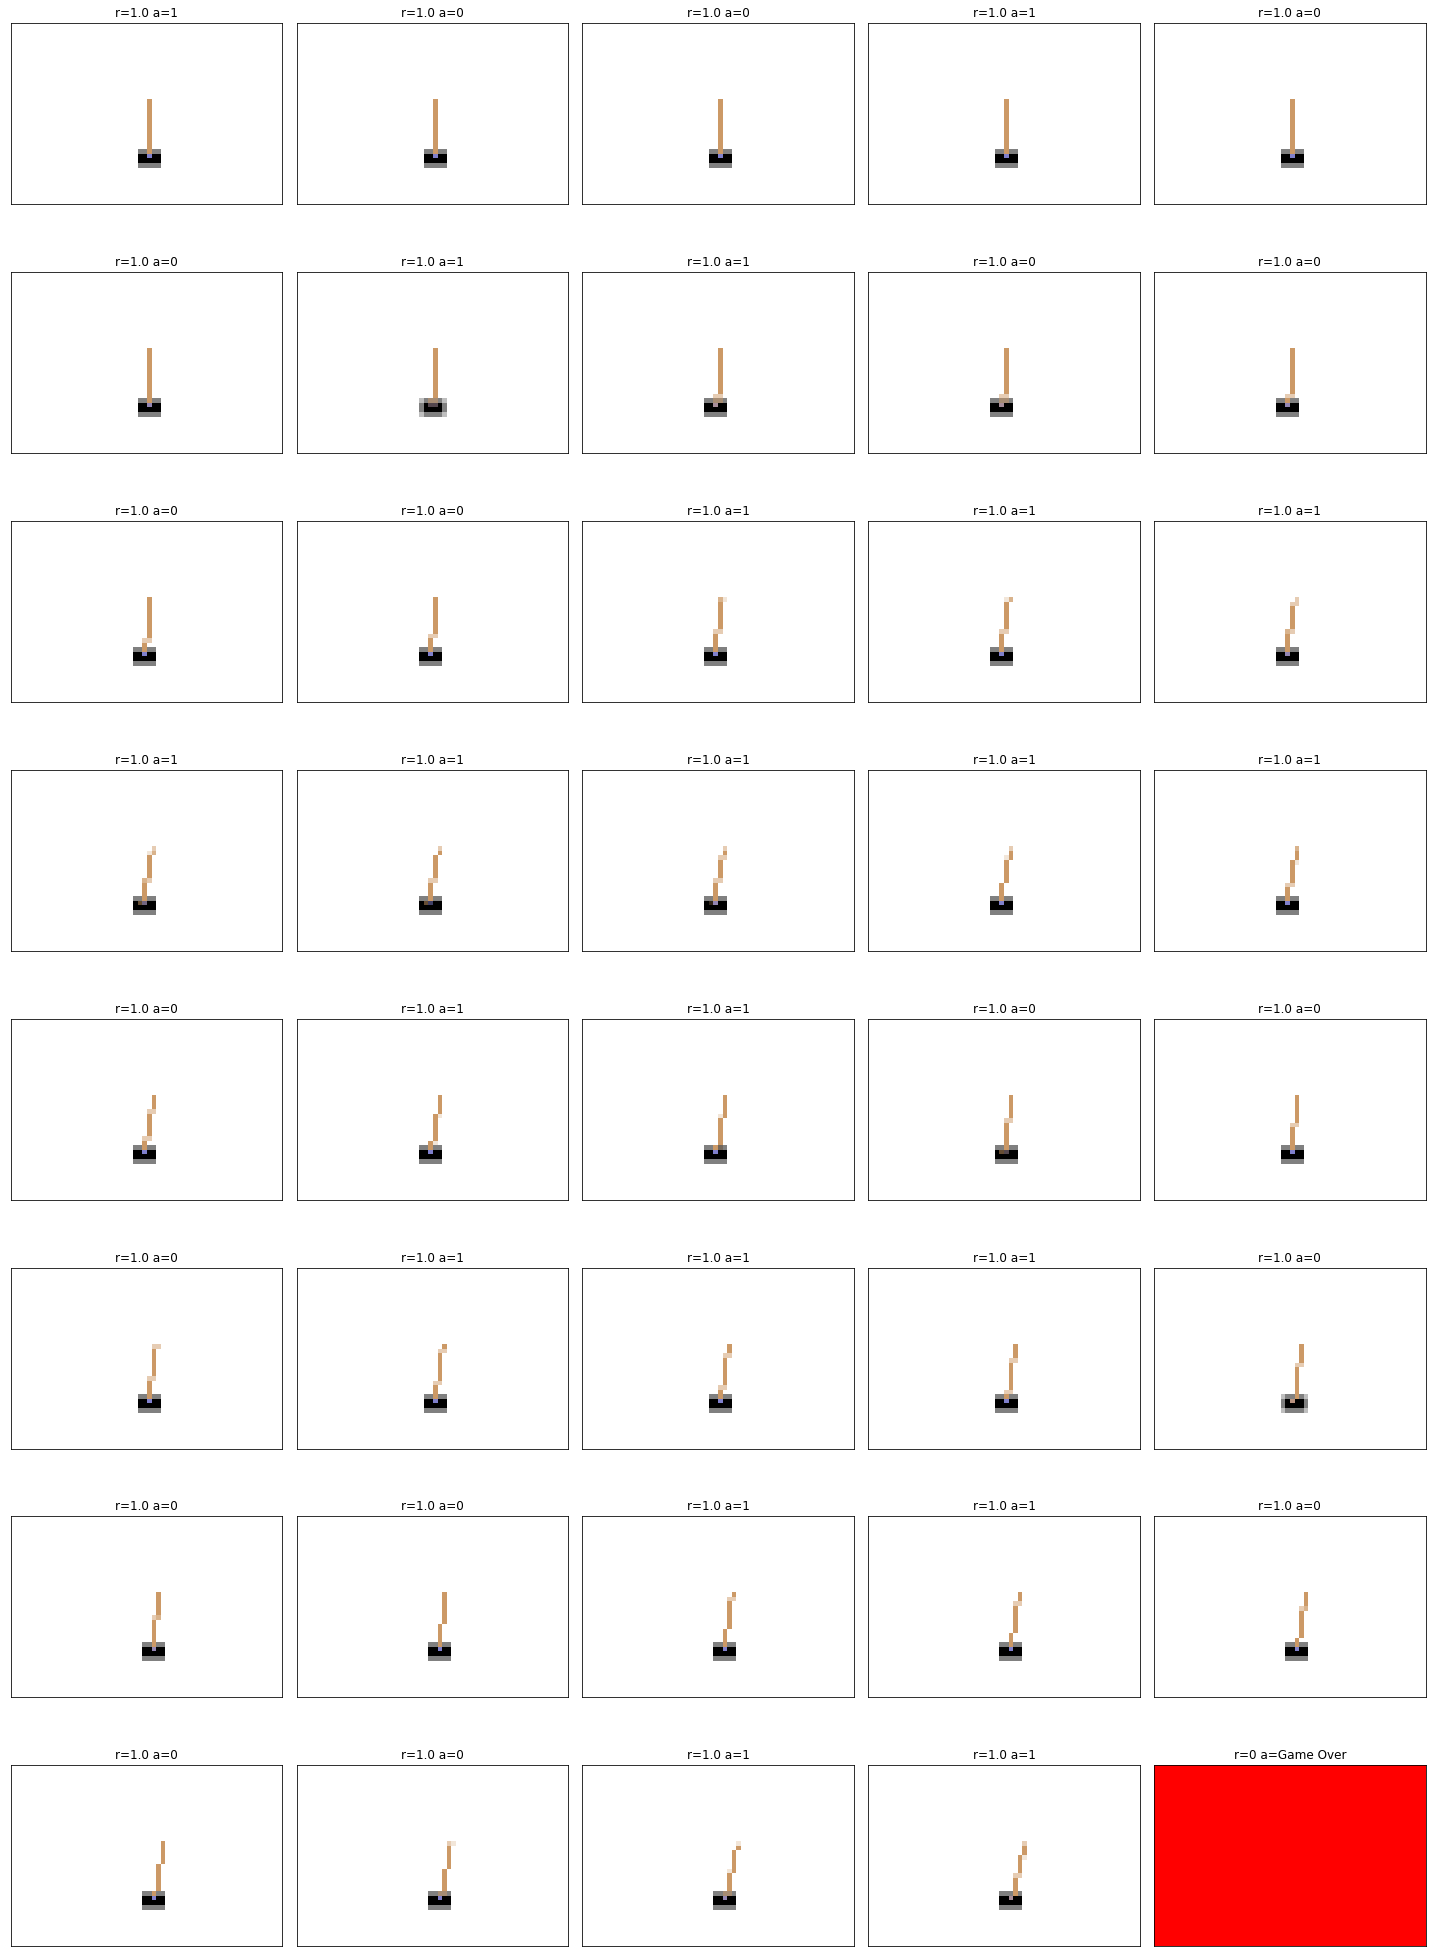

Iteration: 8401, Score: 11
Iteration: 8402, Score: 12
Iteration: 8403, Score: 13
Iteration: 8404, Score: 24
Iteration: 8405, Score: 31
Iteration: 8406, Score: 23
Iteration: 8407, Score: 12
Iteration: 8408, Score: 13
Iteration: 8409, Score: 20
Iteration: 8410, Score: 17
Iteration: 8411, Score: 19
Iteration: 8412, Score: 28
Iteration: 8413, Score: 8
Iteration: 8414, Score: 14
Iteration: 8415, Score: 28
Iteration: 8416, Score: 15
Iteration: 8417, Score: 14
Iteration: 8418, Score: 26
Iteration: 8419, Score: 39
Iteration: 8420, Score: 21
Iteration: 8421, Score: 41
Iteration: 8422, Score: 12
Iteration: 8423, Score: 10
Iteration: 8424, Score: 13
Iteration: 8425, Score: 13
Iteration: 8426, Score: 10
Iteration: 8427, Score: 15
Iteration: 8428, Score: 8
Iteration: 8429, Score: 30
Iteration: 8430, Score: 30
Iteration: 8431, Score: 20
Iteration: 8432, Score: 9
Iteration: 8433, Score: 13
Iteration: 8434, Score: 20
Iteration: 8435, Score: 13
Iteration: 8436, Score: 31
Iteration: 8437, Score: 46
Iter

In [ ]:
# Função auxiliar que atenua a recompensa com a proximdade do fim do episódio
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def trainIters(actor, critic, n_iters):

    optimizerA = optim.Adam(actor.parameters(),lr=0.000001)
    optimizerC = optim.Adam(critic.parameters(),lr=0.0001)
    
    # loop: para cada episódio execute:    
    for iter in range(n_iters):

        state = env.reset()
          
        tela = extractImage(env).to(device)

        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        log_screens = []

        # loop: corpo do episódio 
        for i in count():

            env.render()        
     
            state = torch.FloatTensor(state).to(device)            
            
            # consulta o ator para obter a informação da distribuição de probabilidades das ações
            dist = actor(tela)

            # consulta o crítico para obter a informação de valor do estado atual
            value = critic(state)
            
            # executa a próxima ação
            action = dist.sample()                        
            next_state, reward, done, _ = env.step(action.cpu().numpy()[0])

            if( iter % 100 == 0 ): log_screens.append( { 'i': i, 'action': str(action.cpu().numpy()[0]), 'tela': captureScreen(env), 'reward': reward } )

            next_tela = extractImage(env).to(device)
     
            # efetua os cálculos preliminares e armazena os resultados para o treinamento posterior
            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state
            tela = next_tela

            if done:
                if( iter % 100 == 0 ): log_screens.append( { 'i': i, 'action': 'Game Over', 'tela': captureScreenRed(env), 'reward': 0 } )
                print('Iteration: {}, Score: {}'.format(iter, i))
                scoreFinal=i
                break

        # Terminou o episódio        
        # Treina o modelo    
         
        # Atualiza estado e valor            
        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)

        # Aplica a lógica do gamma 
        returns = compute_returns(next_value, rewards, masks)
        
        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)
                    
        advantage = returns - values
        actor_loss = -(log_probs * advantage.detach()).mean() 
                    # media quadráticas advantage
        critic_loss = advantage.pow(2).mean()    

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()

        torch.cuda.empty_cache()

        if( iter % 100 == 0 ):            
            cols = 5
            rows = math.ceil(len(log_screens)/cols)
            if( rows != 0 ):     

                clear_output(wait=True)
                print( f'A informação abaixo será atualizada a cada 100 interações')
                print( f'Iteração: {iter} score: {scoreFinal}' )

                fig, axs = plt.subplots(ncols=cols,nrows=rows,squeeze=True,figsize=(4*cols,3.5*rows))
                
                for row, axr in enumerate(axs):
                
                    for col, ax in enumerate(axr):

                        i = row*cols+col

                        if( i < len(log_screens)):
                            log_item = log_screens[i]
                            ax.imshow( log_item["tela"] )                    
                            ax.set_title( f'r={log_item["reward"]} a={log_item["action"]}')
                        
                        ax.get_xaxis().set_visible(False)
                        ax.get_yaxis().set_visible(False)

                #plt.suptitle(f'Iteração: {iter} Score: {scoreFinal}')       
                plt.tight_layout()
                plt.show()      
   
    torch.save(actor, 'model/actor.pkl')
    torch.save(critic, 'model/critic.pkl')
    env.close()


    
actor = Actor(image_size,action_size).to(device)
critic = Critic(state_size, action_size).to(device)        

if os.path.exists('model/actor.pkl'):
  actor = torch.load('model/actor.pkl')
  print('Actor Model loaded')

if os.path.exists('model/critic.pkl'):
  critic = torch.load('model/critic.pkl')
  print('Critic Model loaded')    

trainIters(actor, critic, n_iters=10000)

      